Jupyter is a computing environment supporting several interpreted programming languages, cell-by-cell execution, and inline output, including rich tables and charts. It is most often paired with python. It is ideal for quick, iterative data exploration and visualization. All tools and libraries used in this short demonstration are free and open-source.

The complete code can be run by pressing the following button:

<img src="img/RunAll.png" width=800/>

In case the contents of a single cell are changed later, the cell alone can be rerun with the following button. Remeber to also rerun cells whose contents are based on what was just changed. (So perhaps even rerun everything)

<img src="img/RunCell.png" width=800/>

# AI Model
So far we saw how to learn from track telemetry data using data analysis.  [Link to Jupyter Notebook](https://github.com/LuAmma/sem_racebootcamp)


The next step was a mathematical model of the car, using a Graph to optimize the profile the car should drive. The downside is the reliance on precise modelling and quantifying parameters correctly.


That's where machine learning comes in, allowing to use meassured data to predict the values needed for optimising the Graph profile.

We need to import libaries first. Scikit-learn (sklearn for short) is a libary commonly used in machine learining.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as col
import pandas as pd
import math
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_squared_error

Analogous to the physical model we define how strongly the desire to drive fast and the desire to drive efficient are wighted in our optimization. Only the other will be optimized if either is 0.

In [2]:
factor_time = 0.2
factor_efficiency = 0.8

In [3]:
G = nx.DiGraph()
G.add_node("x0_k0",v=0) #add start node
coordinate_set_dict = {"x0_k0": (0,0)}

We now define the states states car is allowed to be in. For this we define a track profile using waypoints that we then interpolate. Change the waypoints in order to change the Track

In [4]:
section_length = 50         # [m]     distance resolution
velocity_spacing = 2        # [km/h]  velocity resolution of the simulation
max_acceleration = 4        # [1]     Unitless integer of how many velocity_spacing steps the car can accelerate or deaccelerte over one section_length

# Define the track profile using waypoints 
# Between waypoints missing the values are obtained with linear interpolation
waypoints = [
    {"s": 0,    "vmax": 0,  "vmin": 0,  "m_above_sea": 100}, # waypoint at start of track needed
    {"s": 50,   "vmax": 30, "vmin": 5, "m_above_sea": 101},
    {"s": 100,  "vmax": 50, "vmin": 10, "m_above_sea": 101.3},
    {"s": 500,  "vmax": 50, "vmin": 20, "m_above_sea": 101},
    {"s": 600,  "vmax": 50, "vmin": 20, "m_above_sea": 102},
    {"s": 750,  "vmax": 50, "vmin": 20, "m_above_sea": 103},
    {"s": 850,  "vmax": 50, "vmin": 20, "m_above_sea": 100},
    {"s": 1599, "vmax": 50, "vmin": 0,  "m_above_sea": 100}, # allow speed to drop again before the end
    {"s": 1600, "vmax": 0,  "vmin": 0 , "m_above_sea": 100}  # waypoint at end of track needed
]

# Create the full track profile out of the waypoints above
waypoint_df = pd.DataFrame(waypoints).set_index("s").sort_index()
s_range = np.arange(waypoint_df.index.min(), waypoint_df.index.max() + 1, section_length)
config = waypoint_df.reindex(waypoint_df.index.union(s_range)).sort_index().interpolate("index").loc[s_range]
config = config.reset_index()


x_max = len(config.index)-1  # index of the end of the last section

# Helper fuction to calculate the Gradient angle inside section x-1
def get_gradient_angle(x):
    return math.atan( (config.loc[x, "m_above_sea"]-config.loc[x-1, "m_above_sea"] ) / section_length)   #in rad

print(config)

       s  vmax       vmin  m_above_sea
0      0   0.0   0.000000   100.000000
1     50  30.0   5.000000   101.000000
2    100  50.0  10.000000   101.300000
3    150  50.0  11.250000   101.262500
4    200  50.0  12.500000   101.225000
5    250  50.0  13.750000   101.187500
6    300  50.0  15.000000   101.150000
7    350  50.0  16.250000   101.112500
8    400  50.0  17.500000   101.075000
9    450  50.0  18.750000   101.037500
10   500  50.0  20.000000   101.000000
11   550  50.0  20.000000   101.500000
12   600  50.0  20.000000   102.000000
13   650  50.0  20.000000   102.333333
14   700  50.0  20.000000   102.666667
15   750  50.0  20.000000   103.000000
16   800  50.0  20.000000   101.500000
17   850  50.0  20.000000   100.000000
18   900  50.0  18.664887   100.000000
19   950  50.0  17.329773   100.000000
20  1000  50.0  15.994660   100.000000
21  1050  50.0  14.659546   100.000000
22  1100  50.0  13.324433   100.000000
23  1150  50.0  11.989319   100.000000
24  1200  50.0  10.654206

Now some functions that will later be used are prepared.

The first thing is loading the data. The data from all past attempts on the track are imported, following the principle *"You can't afford not to use avialable data"*. For this the files are appended behind one another with some extra logic to make sure the counters in the data are correctly increasing. The data is then cleaned up.

In [18]:
def load_data():
    # Loading Data
    filenames = ['BE_sample_data_1.csv', 'BE_sample_data_2.csv', 'BE_sample_data_3.csv', 'BE_sample_data_4.csv']
    
    df_list = []
    lap_offset = 0
    
    # make sure that the lap counter is one increasing value
    for file in filenames:
        temp_df = pd.read_csv(file, sep=',', low_memory=False)
        temp_df.columns = [col.lower() for col in temp_df.columns]
    
        if 'lap_lap' in temp_df.columns:
            temp_df['lap_lap'] += lap_offset
            lap_offset = temp_df['lap_lap'].max()+1  # Update offset for next file
    
        df_list.append(temp_df)
    
    df = pd.concat(df_list, ignore_index=True)
    df.ffill(inplace=True)
    df.reset_index(drop=True, inplace=True)
       
    # Cleanup
    df.columns = [col.lower() for col in df.columns]
    df.reset_index(drop=True, inplace=True)
    df.ffill(inplace=True)

    return df


The data currently has the form of time series, but what we want are statistical variables stating the behaviour within a section. That's what the next function does. It takes all data, splits them into bins that correspond to one track section and then calculates macroscopic values for each bin.

To gain more data, the procedure is then repeated after shifting the bins by a small distance.

In [19]:
def aggregate_data(df):
    # Get max lap_dist, rounded up to a multiple of section_length
    max_dist = np.ceil(df['lap_dist'].max() / section_length) * section_length
    
    # Define how data from the bins should be aggregated into quantities
    agg_behavior = {
        'E_Engine': pd.NamedAgg(column='jm3_netjoule', aggfunc=lambda x: x.max() - x.min()),  # Total Energy
        'time': pd.NamedAgg(column='obc_timestamp', aggfunc=lambda x: x.max() - x.min()),     # total time
        's': pd.NamedAgg(column='lap_dist', aggfunc='first'),                                 # distance from start of track to start of section
        'v1': pd.NamedAgg(column='gps_speed', aggfunc='first'),                               # speed at the start of the section
        'v2': pd.NamedAgg(column='gps_speed', aggfunc='last')                                 # speed at the end of the section
    }

    results = []

    # define 4 shift values, between 0 and section_length
    shifts = np.linspace(0, section_length, 4, endpoint=False)
    
    for shift in shifts:
        bins = np.arange(0, max_dist, section_length)+shift  # Create bins that contain data corresponding to a section, shifted to by shift value 
    
        df['bin'] = pd.cut(df['lap_dist'], bins=bins, right=False)
    
        # Group and aggregate
        grouped = df.groupby(['lap_lap', 'bin'], observed=True).agg(**agg_behavior).reset_index()

        #transform speed in km/h into m/s
        grouped['v1'] = grouped['v1'] / 3.6
        grouped['v2'] = grouped['v2'] / 3.6
        
        results.append(grouped)
    
    data = pd.concat(results, ignore_index=True).drop(columns = ['lap_lap','bin'])
    
    return data

Next we define how the model is to be trained. For this we create a seperate python class. In the constructor `__init__` the model is trained. The exact specification of the model is passed as an argument, this will be discussed later. Only 90% of the data is used for trainig, in order to have 10% of the data to gauge how good the model is.

The `predict` function can then be used to predict the time and Energy used for a section. The arguments "gradient angle" and "section length" are also passed for compatibility with the physical car model, but not used in this model. In fact the evelation of the track is not considered at all in this model, while it was included in the physical model.

There is also a `plot` function that we can use to further evaluate the model, but it's not important what it does exactly.

In [24]:
class ImpossibleState(Exception):
    pass

class AICarModel:
    def __init__(self, model=model_nn_wide):
        df = load_data()
        agg_df = aggregate_data(df)
        self._model = model


        X = agg_df[['v1','v2']]          # Features, quantities that are known
        y = agg_df[['E_Engine','time']]  # Target, quantities that we want to know

        # Split the data (90% training, 10% testing), so we are later able to evaluate the model
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        
        # Train the model
        self._model.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred = self._model.predict(X_test)      

        # Compare with test data, and calculate indicators of how good the predictions are.
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error: {mse}")
        rmse = np.sqrt(mse)
        print(f"Root Mean Squared Error: {rmse}")
        for i, col in enumerate(y.columns):  # y is agg_df[['E_Engine','time']]
            corr = np.corrcoef(y_test.iloc[:, i], y_pred[:, i])[0, 1]
            print(f"Correlation for {col}: {corr}")



    def predict(self,gradient_angle, v1, v2, section_length):  
        df = pd.DataFrame([[v1,v2]],columns=["v1","v2"])  # Format Data correctly
        prediction = self._model.predict(df)
        Energy_Motor, time = prediction[0]

        # do some basic plausibility checks to combat mispredictions
        if time <= 0: # No negative time
            raise ImpossibleState("Negative time") 
        if Energy_Motor <= 0: # No regaining energy
            Energy_Motor = 0      
        return Energy_Motor, time


    
    def plot(self):
        # Define range of acceleration and velocity
        v1_values = np.linspace(0, 50, 50)       # velocity in m/s
        v_diff = np.linspace(-5, 10, 20)         # change in velocity in m/s
    
        # Create a grid of all combinations
        v1_grid, v_diff_grid = np.meshgrid(v1_values, v_diff, indexing='ij')
        v1_flat = v1_grid.ravel()
        v_diff_flat = v_diff_grid.ravel()
    
        # Create DataFrame for prediction
        df_all = pd.DataFrame({
            'v1': v1_flat / 3.6,
            'v2': (v1_flat + v_diff_flat) / 3.6,
        })
    
        # Predict
        prediction = self._model.predict(df_all)
        E_total_flat = prediction[:, 0]
        time_flat = prediction[:, 1]
    
        # Reshape to grid
        E_matrix = E_total_flat.reshape(len(v1_values), len(v_diff))
        time_matrix = time_flat.reshape(len(v1_values), len(v_diff))
    
        # Plot both using subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
        im0 = axes[0].imshow(
            E_matrix.T,
            aspect='auto',
            origin='lower',
            extent=[v1_values.min(), v1_values.max(), v_diff.min(), v_diff.max()],
            cmap='viridis'
        )
        axes[0].set_title("E_total for change from v1 to v2")
        axes[0].set_xlabel("Velocity v1 [km/h]")
        axes[0].set_ylabel("Change in Velocity [km/h]")
        axes[0].set_xticks(np.linspace(v1_values.min(), v1_values.max(), 5))
        axes[0].set_yticks(np.linspace(v_diff.min(), v_diff.max(), 6))
        fig.colorbar(im0, ax=axes[0], label='E_total')
    
        im1 = axes[1].imshow(
            time_matrix.T,
            aspect='auto',
            origin='lower',
            extent=[v1_values.min(), v1_values.max(), v_diff.min(), v_diff.max()],
            cmap='viridis'
        )
        axes[1].set_title("Time for change from v1 to v2")
        axes[1].set_xlabel("Velocity v1 [km/h]")
        axes[1].set_ylabel("Change in Velocity [m/s]")
        axes[1].set_xticks(np.linspace(v1_values.min(), v1_values.max(), 5))
        axes[1].set_yticks(np.linspace(v_diff.min(), v_diff.max(), 6))
        fig.colorbar(im1, ax=axes[1], label='Time')
    
        plt.tight_layout()
        plt.show()


Next Pipelines are defined. Pipelines are some kind of "recipe" of steps that are taken for training models.
There are many otions to construct those pipelines. The following options are written there:

* Linear: assumes the the car can be modelled by polynomials up to degree 3.
* Lasso: assumes the the car can be modelled by polynomials up to degree 4. Additionally forces the model to be simple by using parameter alpha
* NN Wide: uses a neural network to model the data. Here three layers are used, with 128, 256 and 128 nodes respecitvely.
* NN Deep: uses a neural network to model the data. Here eight layers are used, with something between 4 and 64 nodes per layer.

If you want you can take a look at the [sklearn website](https://scikit-learn.org/stable/) and experiment with the parameters. Particularily the effect of the composition of the neural network can be explored.

Note that usually the [pytorch](https://pytorch.org/) libary is used for neural networks instead of sklearn, but as sklearn is easier it is used here.

In [25]:
pipeline_linear = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear', MultiOutputRegressor(
        LinearRegression()
    ))
])


pipeline_lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', MultiOutputRegressor(
        Lasso(alpha = 1, max_iter = 20000)
    ))
])

pipeline_nn_wide = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('nn', MultiOutputRegressor(
       MLPRegressor(
           hidden_layer_sizes=(128,256,128), 
           activation='relu', 
           random_state=42, 
           max_iter=5000
       )
    ))
])

pipeline_nn_deep = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('nn', MultiOutputRegressor(
       MLPRegressor(
           hidden_layer_sizes=(32,16,64,16, 4, 16, 32, 16), 
           activation='relu', 
           random_state=42, 
           max_iter=5000
       )
    ))
])


Now one of the pipelines is used to initalise the model.

In order to find a model and parameter configuration that fits well, we can look at the following indicators:
* Low Mean Squared Error and Root Mean Squared Error for the prediction
* Large Correlation between correct values and predictions.

These quantities are printed while training the model and are shown below after running the code.

Sadly simply minimising or maximising those quantities also does not work, as the following picture illustrates. While the red curve in the picture fits the Data better, it will likely do worse in predicting new data points. This phenomenon is called overfitting. Because of this tradeoff the model has to be simple, but still expressive.

<img src="img/overfitting.png" width=800/>

Luckily we can also use a different approach to check if the model is suitable.

Using the `plot` function the energy usage and time for passing a sector is predicted. On the x-axis is the velocity at the start of the section, at the y-axis by how much this velocity changes. The plots can be compared to the expectation of how the car should react.

In particular:
1. The Energy usage should be the highest when driving fast and accelerating further
2. When deaccelerating, the energy usage should be close to zero, as the engine can be switched off in this state
3. At high speeds the energy should be higher than at low speeds
4. The time should be porportional to the inverse value of the speed, and as such high in the bottom left corner and low everywhere else

Additionally things that do not look smooth should be given a closer look. Is there an explanation for the higher values around the magenta line with the question mark, or does that might hint at overfitting?

<img src="img/PlotInterpretation.png" width=800/>

Mean Squared Error: 508920.00631594576
Root Mean Squared Error: 713.3862952958557
Correlation for E_Engine: 0.8531683196236834
Correlation for time: 0.8346690633457945


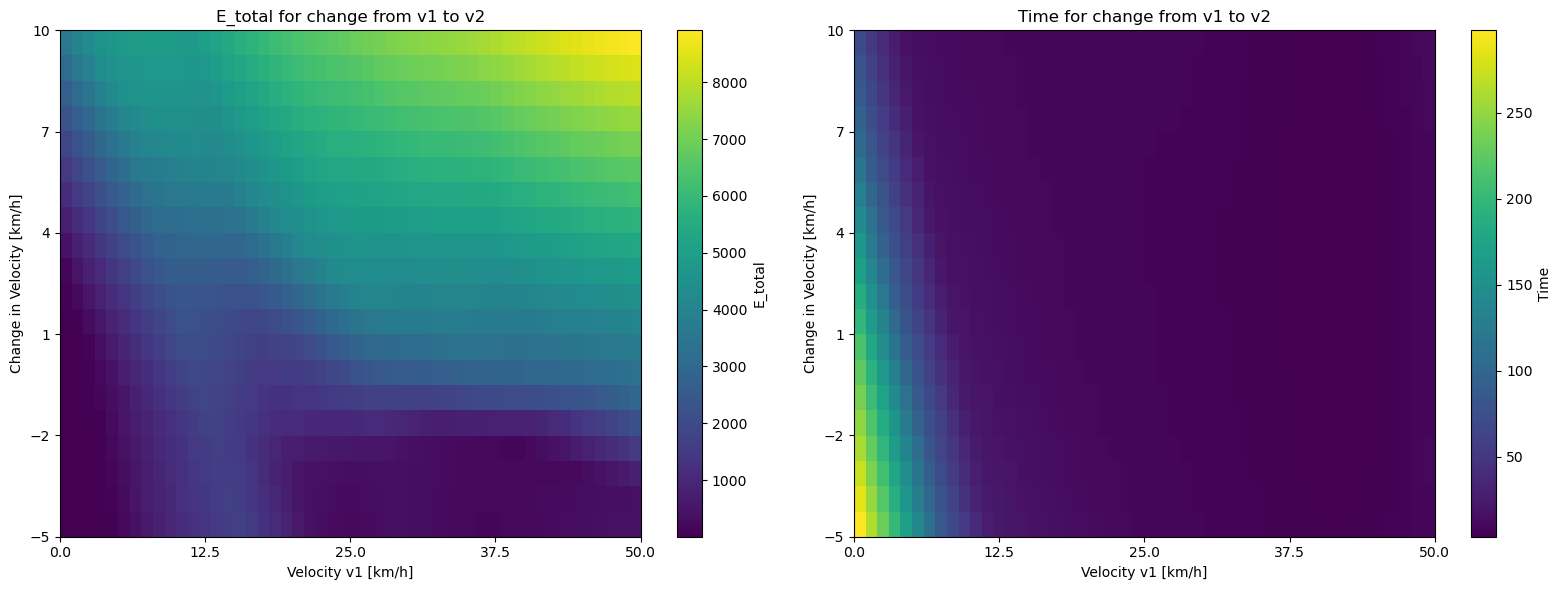

In [26]:
# Use physical formulas to simulate the behaviour of the car
# model = PhysicalCarModel()


# Use a machinelearing model to predict the behaviour of the car
# Uncomment to try out different ones
# model = AICarModel(pipeline_linear)
# model = AICarModel(pipeline_lasso)
model = AICarModel(pipeline_nn_wide)
# model = AICarModel(pipeline_nn_deep)

model.plot()

Building the graph works exactly the same as with the physical car model, the code is unchanged. To be easier to run everything is in a single cell.

In [23]:
for x in range (1, x_max+1):   
    # change vmin and vmax from the track config to discrete boundaries
    k_min = int(np.ceil(config.loc[x, "vmin"] / velocity_spacing))
    k_max = int(np.floor(config.loc[x, "vmax"] / velocity_spacing))

    for k in range(k_min, k_max + 1):
        v = k * velocity_spacing
        node_name = f"x{x}_k{k}"
        G.add_node((node_name), v=v)
        coordinate_set_dict[node_name] = (x*section_length, v) # add to dictionary to later print it at correct position
        
        for kold in range(k-max_acceleration,k+max_acceleration+1):
            if G.has_node(f"x{x-1}_k{kold}"):
                vold = kold*velocity_spacing

                gradient_angle = get_gradient_angle(x)
                vold_mps       = vold / 3.6
                v_mps          = v / 3.6            

                try:
                    # Use the car model to predict the Energy and time needed to pass the section
                    E_Engine, time = model.predict(gradient_angle, vold_mps, v_mps, section_length)
                except ImpossibleState:
                    # Transition not possible
                    continue  # Skip this iteration

                # As adding up speed and fuel usage is comparing apples and oranges, we have to prescale what we calculated 
                # so that the speed and efficiency factors have the effect we hope for.
                cost_econ = E_Engine / 2500
                cost_speed = time / 10

                edge_weight = factor_time*cost_speed + factor_efficiency*cost_econ
                G.add_edge(f"x{x-1}_k{kold}", node_name, weight=edge_weight, time=time, energy=E_Engine)



x_end = len(config.index)-1
k_end = int(np.ceil(config.loc[len(config.index)-1]["vmin"] / velocity_spacing))

nodelist = nx.dijkstra_path(G, "x0_k0",f"x{x_end}_k{k_end}")

outputlist = []
for i in range(len(config.index)):
     outputlist.append(G.nodes[nodelist[i]]["v"])

output = pd.DataFrame(outputlist)
output.rename(columns={0:"Speed optimal"}, inplace = True)
output['distance'] = output.index * section_length

total_time = 0
for u, v in zip(nodelist[:-1], nodelist[1:]):
    total_time += G.edges[u, v].get("time", 0)
print("Total time (seconds):", total_time)


total_energy = 0
for u, v in zip(nodelist[:-1], nodelist[1:]):
    total_energy += G.edges[u, v].get("energy", 0)
print("Total energy (joules):", total_energy)

weight_list = []
attributelist = nx.get_edge_attributes(G,'weight')
for edge in G.edges:
    weight_list.append(attributelist[edge])



# plot
fig, ax = plt.subplots(figsize=(10, 6))

nx.draw(
    G,
    pos=coordinate_set_dict,
    ax=ax,
    with_labels=False,
    node_color='blue',
    edge_color='lightgrey',
    node_size=2,
)
ax.plot(output['distance'], output['Speed optimal'], color='blue', linewidth=2, label='Optimal Speed')
ax.set_xlabel('Distance [m]')
ax.set_ylabel('Speed [km/h]')
ax.set_title('Optimal Path')
ax.axis('on')
plt.tick_params(axis='both', which='both', bottom=True, left=True, labelbottom=True, labelleft=True)
plt.show()